# Benchmarking Foundation Models Notebook 

Authors:
- Helio Halperin (heliohalperin@gmail.com)
- Simon Lee (simonlee711@g.ucla.edu)

2024

In [ ]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
!pip install git+https://github.com/huggingface/transformers.git

!pip install transformers datasets[s3] sagemaker --upgrade
!pip install scikit-learn
!pip install accelerate==0.21.0
!pip install fastprogress
!pip install lightgbm

In [3]:
!pwd

/root/antibiotics-fm-benchmark


In [4]:
# Basic imports
import numpy as np
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn

# AWS imports
import boto3
from sagemaker import get_execution_role

# I/O imports
from io import StringIO

# Progress and visualization imports
from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Sklearn metrics imports
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Transformers imports
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, 
    DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, 
    AdamW, get_scheduler
)
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_metric

# PyTorch data handling
from torch.utils.data import DataLoader

from scripts.train_test_split import custom_train_test_split
from scripts.encoder import encode_texts
from scripts.train_test import evaluate_antibiotics_with_confidence_intervals, print_results
from scripts.plot import plot_roc_curves, plot_auprc_curves, calculate_confidence_interval

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# read in data

In [5]:
data = pd.read_csv("./data/antibiotics_labels.csv")
display(data)

,subject_id,stay_id,hadm_id,arrival,triage,medrecon,vitals,codes,pyxis,patient_paragraph,...,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,LEVOFLOXACIN,NITROFURANTOIN,OXACILLIN,RIFAMPIN,TETRACYCLINE,TRIMETHOPRIM/SULFA,VANCOMYCIN
0,10002443,33425241,21329021,"Patient 10002443, a 53 year old white male, ar...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2183-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10002443, a 53 year old white male, ar...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,10005858,39055405,29352282,"Patient 10005858, a 62 year old white female, ...","At triage: temperature was 102.7, pulse was 93...",The patient was previously taking the followin...,The patient had the following vitals: At 2172-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10005858, a 62 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,10014078,38676365,25809882,"Patient 10014078, a 60 year old unable to obta...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014078, a 60 year old unable to obta...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,19989126,35420737,22853928,"Patient 19989126, a 45 year old asian female, ...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19989126, a 45 year old asian female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5978,19990821,35896332,27777812,"Patient 19990821, a 70 year old unknown male, ...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient has no diagnostic codes recorded.,The patient received the following medications...,"Patient 19990821, a 70 year old unknown male, ...",...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5979,19991805,34001852,23646288,"Patient 19991805, a 80 year old white female, ...","At triage: temperature was 97.9, pulse was 67....",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19991805, a 80 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5980,19994772,37554330,29199248,"Patient 19994772, a 54 year old white female, ...","At triage: temperature was 96.7, pulse was 79....",The patient was previously taking the followin...,The patient had the following vitals: At 2181-...,The patient received the following diagnostic ...

In [6]:
# List of antibiotics we are interested in
############################################
## We may or may not study NITROFURANTOIN ## 
## Because only 6% of patients were       ##
## prescribed it                          ##
############################################

antibiotics = ['CLINDAMYCIN', 'ERYTHROMYCIN', 'GENTAMICIN', 'LEVOFLOXACIN', 
               'OXACILLIN', 'TETRACYCLINE', 'TRIMETHOPRIM/SULFA', 
               'VANCOMYCIN']

In [7]:
# # Split data into 80% and 20$ cuts
train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print('TRAIN:', len(train), 'TEST:', len(test))

TRAIN: 4844 TEST: 599


# DistilBERT (baseline)

In [17]:
# Generate Embeddings for each set of data
## We can plug in any models found on the huggingface platform
##
X_train = encode_texts('distilbert-base-uncased', train['patient_paragraph'].tolist())
X_test = encode_texts('distilbert-base-uncased', test['patient_paragraph'].tolist())

In [ ]:

## Evaluate 
distilbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)



# pickle files. Saving variables into pickle files. Save all your results in these special files. 

In [8]:
import pickle
def save_pickle(results, filename):
    """
    Creates a new pickle file

    results: the name of the variable
    filename: the name of the file
    """
    filename = f"{filename}.pickle"

    file_path=f'./results/{filename}'
    with open(file_path, 'wb') as file:
        pickle.dump(results, file)

    print(f"The variable {filename} has been saved successfully.")

def load_pickle(filename):
    """
    Loads in the pickle file

    filename: the name of the file
    """
    file_path=f'./results/{filename}.pickle'
    loaded_data = None
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)

    print(f"The variable {filename} has been loaded successfully.")

    return loaded_data


In [ ]:
distilbert_results = load_pickle('DistilBERT')

# Biomegatron

In [ ]:
X_train = encode_texts('EMBO/BioMegatron345mUncased', train['patient_paragraph'].tolist())
X_test = encode_texts('EMBO/BioMegatron345mUncased', test['patient_paragraph'].tolist())
## Make sure to rename
biomegatron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biomegatron_results)

save_pickle(biomegatron_results, "biomegatron")
biomegatron_results = load_pickle('biomegatron')

# Took too long, should use AWS

# Medbert

In [ ]:
X_train = encode_texts("Charangan/MedBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("Charangan/MedBERT", test['patient_paragraph'].tolist())
## Make sure to rename
medbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(medbert_results)

save_pickle(medbert_results, "medBERT")
medbert_results = load_pickle('medBERT')

Bluebert

In [14]:
X_train = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", train['patient_paragraph'].tolist())
X_test = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", test['patient_paragraph'].tolist())
## Make sure to rename
bluebert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(bluebert_results)

save_pickle(bluebert_results, "BlueBERT")
bluebert_results = load_pickle('BlueBERT')

Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:44<05:12, 44.66s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [01:30<04:30, 45.10s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [02:22<04:01, 48.25s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [03:07<03:08, 47.14s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [03:52<02:18, 46.21s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [04:39<01:33, 46.58s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [05:26<00:46, 46.61s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [06:10<00:00, 46.32s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7827 +/- 0.0309, MCC: 0.4042, ROC-AUC: 0.7379 +/- 0.0384, PRC-AUC: 0.7684 +/- 0.0492
Results for ERYTHROMYCIN:
  Test - F1: 0.6517 +/- 0.0409, MCC: 0.3461, ROC-AUC: 0.7363 +/- 0.0396, PRC-AUC: 0.6699 +/- 0.0625
Results for GENTAMICIN:
  Test - F1: 0.9777 +/- 0.0083, MCC: 0.3667, ROC-AUC: 0.6812 +/- 0.1121, PRC-AUC: 0.9667 +/- 0.0197
Results for LEVOFLOXACIN:
  Test - F1: 0.8189 +/- 0.0280, MCC: 0.4655, ROC-AUC: 0.7801 +/- 0.0393, PRC-AUC: 0.8290 +/- 0.0397
Results for OXACILLIN:
  Test - F1: 0.7927 +/- 0.0288, MCC: 0.4405, ROC-AUC: 0.7641 +/- 0.0381, PRC-AUC: 0.7874 +/- 0.0458
Results for TETRACYCLINE:
  Test - F1: 0.9048 +/- 0.0186, MCC: 0.3795, ROC-AUC: 0.6539 +/- 0.0551, PRC-AUC: 0.8612 +/- 0.0385
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9087 +/- 0.0181, MCC: 0.4099, ROC-AUC: 0.7335 +/- 0.0539, PRC-AUC: 0.8943 +/- 0.0360
Results for VANCOMYCIN:
  Test - F1: 0.7341 +/- 0.0344, MCC: 0.3764, ROC-AUC: 0.7733 +/- 0.0361, PRC-AUC: 0.7958 +/- 0

Biobert

In [ ]:
X_train = encode_texts("pritamdeka/BioBert-PubMed200kRCT", train['patient_paragraph'].tolist())
X_test = encode_texts("pritamdeka/BioBert-PubMed200kRCT", test['patient_paragraph'].tolist())
## Make sure to rename
biobert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biobert_results)

save_pickle(biobert_results, "BioBERT")
biobert_results = load_pickle('BioBERT')

In [15]:
biobert_results = load_pickle('BioBERT')
medbert_results = load_pickle('medBERT')
distilbert_results = load_pickle('DistilBERT')
biomegatron_results = load_pickle('biomegatron')
bluebert_results = load_pickle('BlueBERT')

The variable BioBERT has been loaded successfully.
The variable medBERT has been loaded successfully.
The variable DistilBERT has been loaded successfully.
The variable biomegatron has been loaded successfully.
The variable BlueBERT has been loaded successfully.


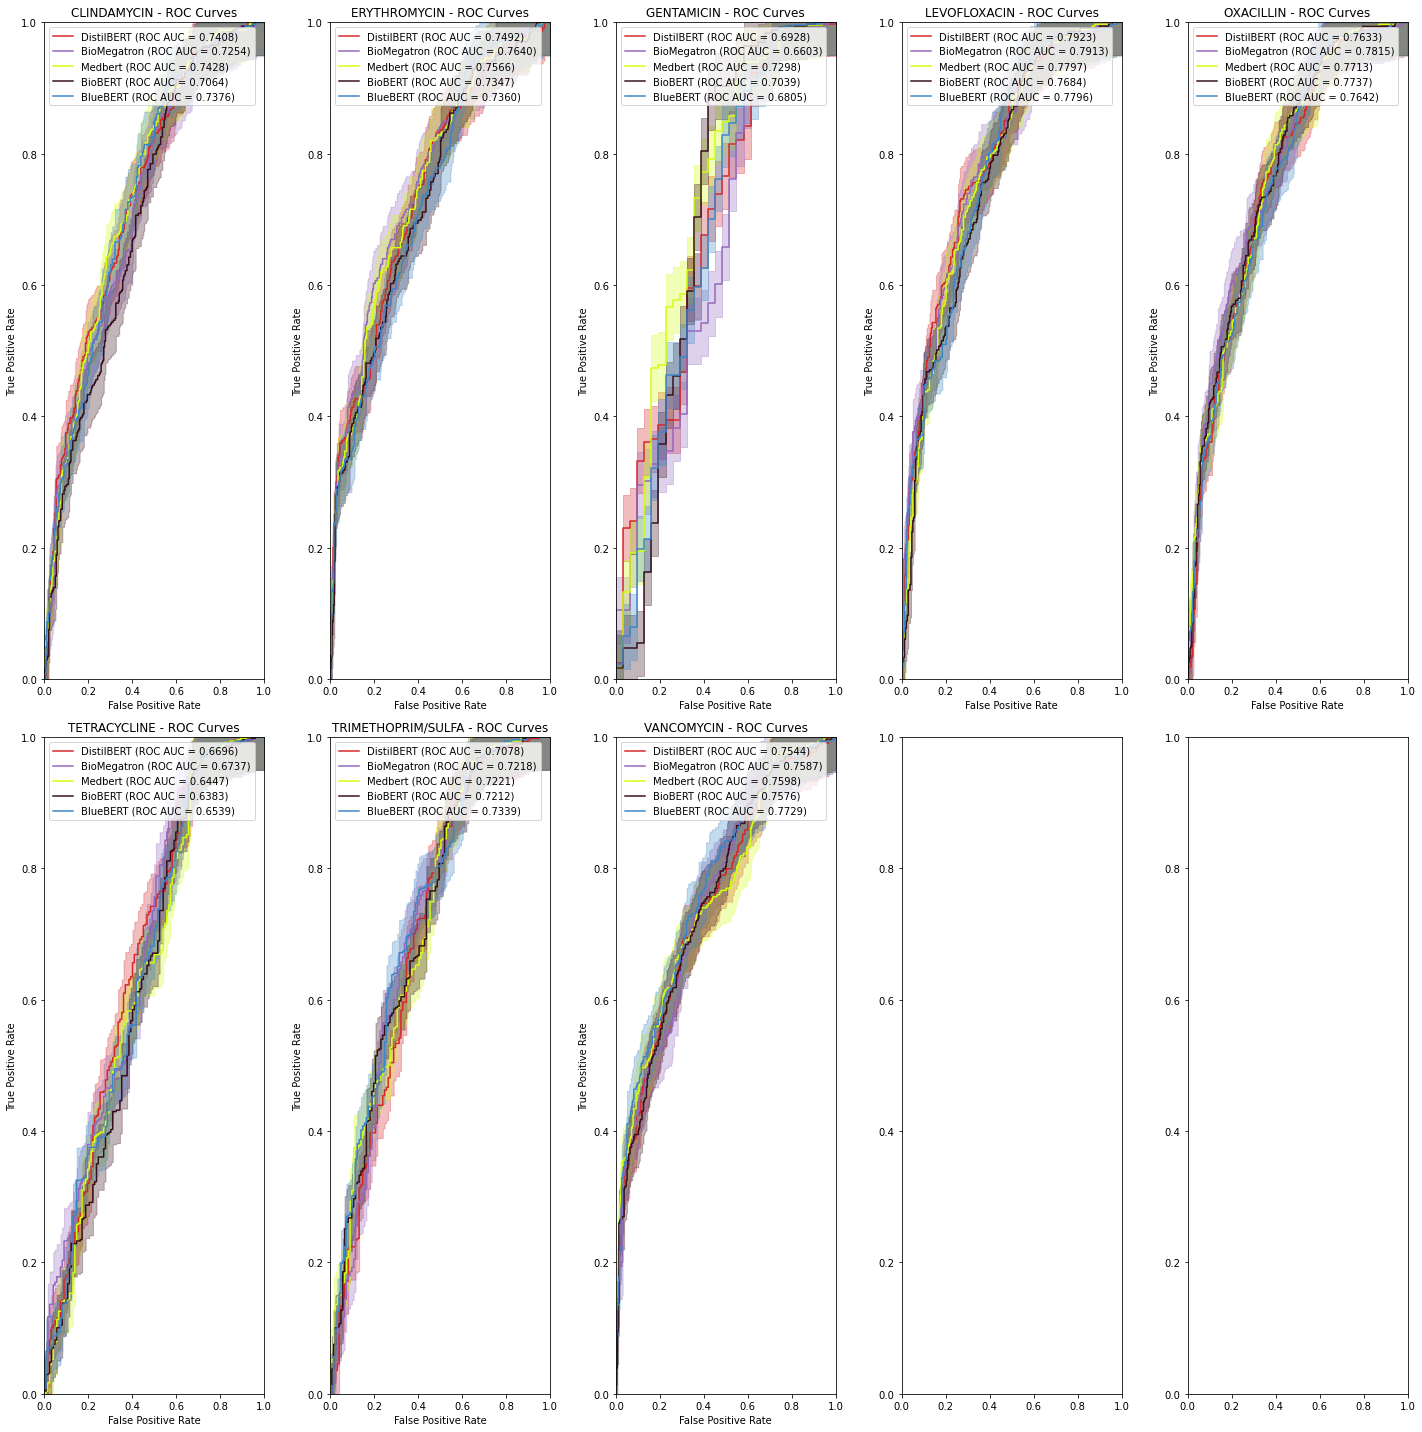

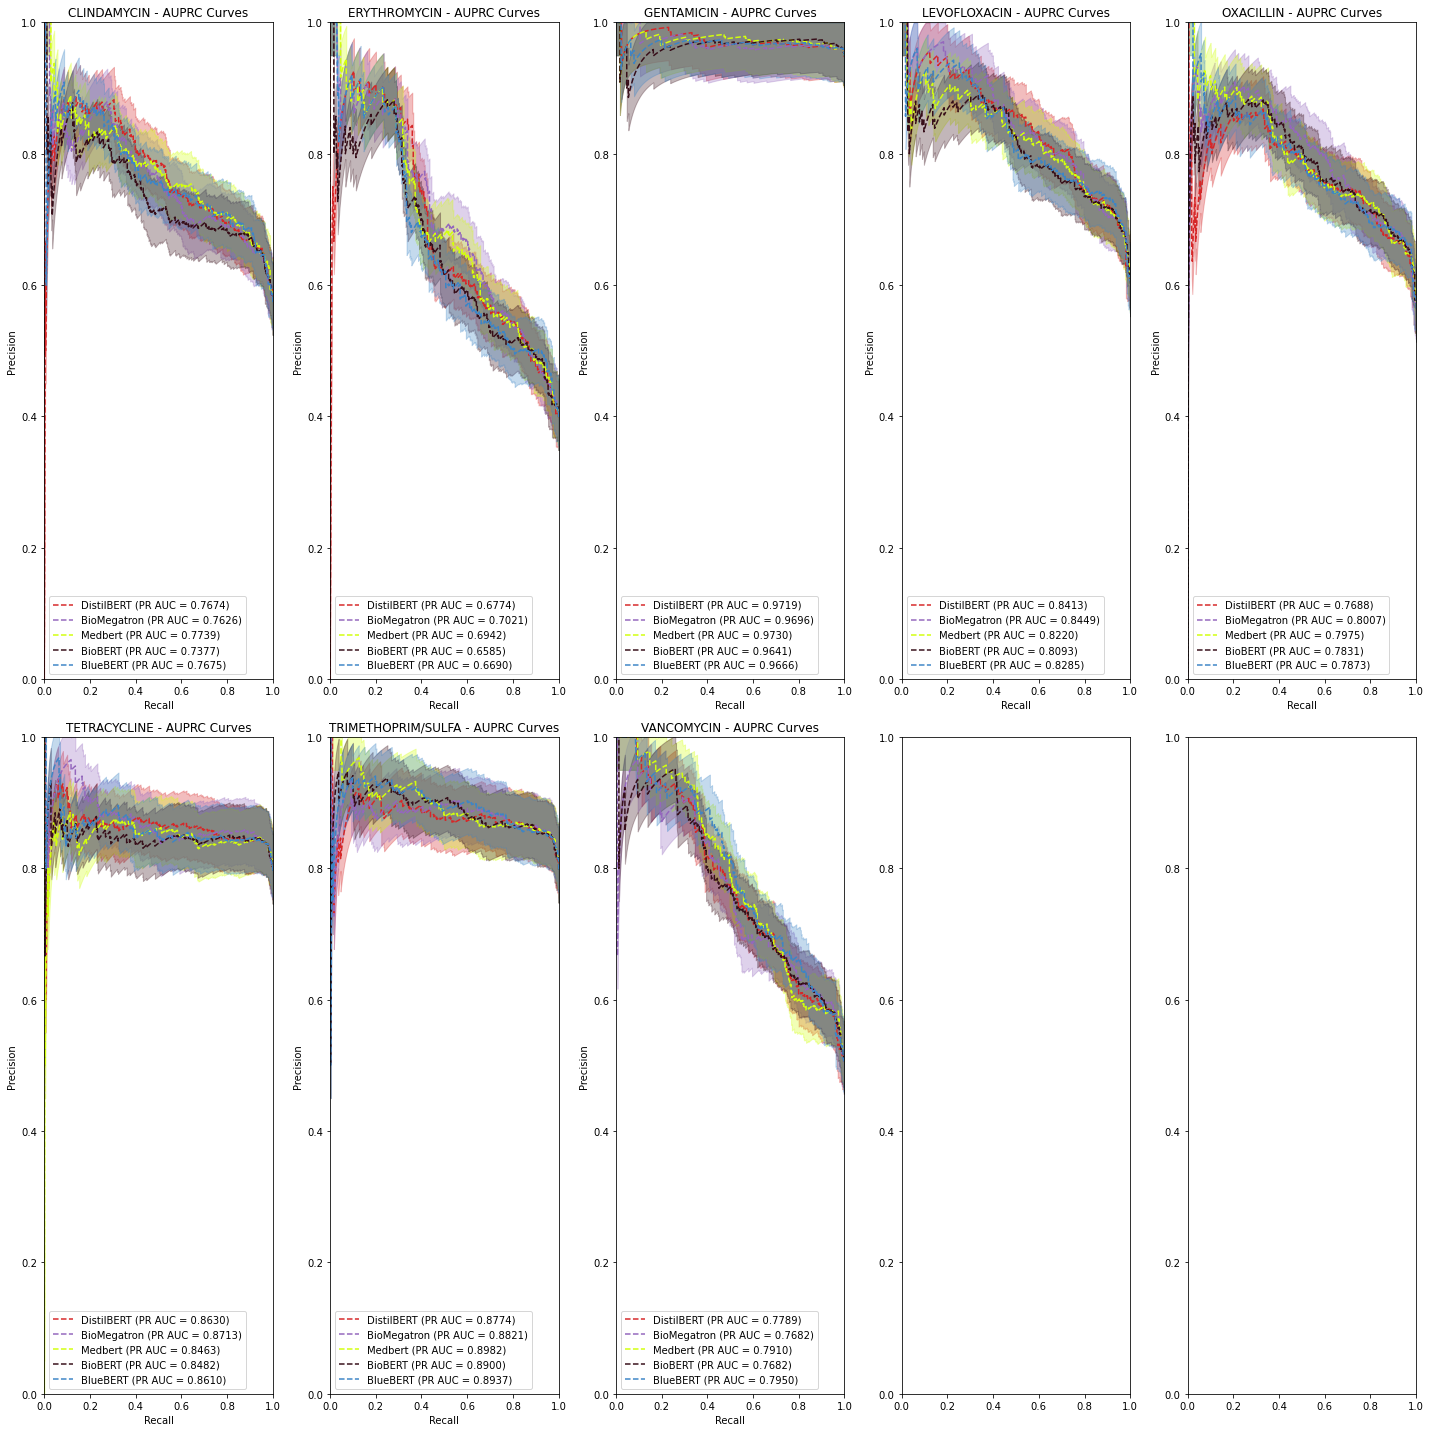

In [16]:
model_colors = {
    "DistilBERT": '#d62728',
    "BioMegatron": '#9467bd',
    "Medbert": "#d3ff0d",
    "BioBERT": "#370e19",
    "BlueBERT": "#3d85c6"
}

# Dictionaries with their corresponding model names
dictionaries = [
    (distilbert_results, "DistilBERT"),
    (biomegatron_results, "BioMegatron"),
    (medbert_results, "Medbert"),
    (biobert_results, "BioBERT"),
    (bluebert_results, "BlueBERT")
]
plot_roc_curves(antibiotics, dictionaries, model_colors)
plot_auprc_curves(antibiotics, dictionaries, model_colors)